In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from __future__ import annotations
from dataclasses import dataclass, field
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Any

In [185]:
import RaTag.cuts as cuts # type: ignore
import RaTag.dataIO as dataIO # type: ignore
import RaTag.config as config # type: ignore
import RaTag.transport as transport # type: ignore
from RaTag.waveforms import PMTWaveform  # type: ignore
import RaTag.measurement as meas # type: ignore
import RaTag.plotting as plotting # type: ignore
# import RaTag.measurements as meas

In [7]:
base_dir = Path('/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN2_EL3kVcm_1GSsec')
meas_path = base_dir / 'FieldScan_1GSsec_EL2470_Gate70'
wfm_paths = sorted(meas_path.glob('*.wfm'))

In [8]:
EL_gap = 0.8 # cm
drift_length = 1.4 # cm
gas_density=4.91e19 # cm^-3
bs_t_window=(-1.5e-5, -1.0e-5)  # 15-10 us before trigger
t_s1 = -3.74e-6  # s1 time (s)

# Test waveforms module

In [13]:
wf = dataIO.load_wfm(str(wfm_paths[0]))

<Axes: title={'center': 'RUN2_21082025_Gate70_Anode2470_P3_0000.wfm'}, xlabel='Time (µs)', ylabel='Signal (V)'>

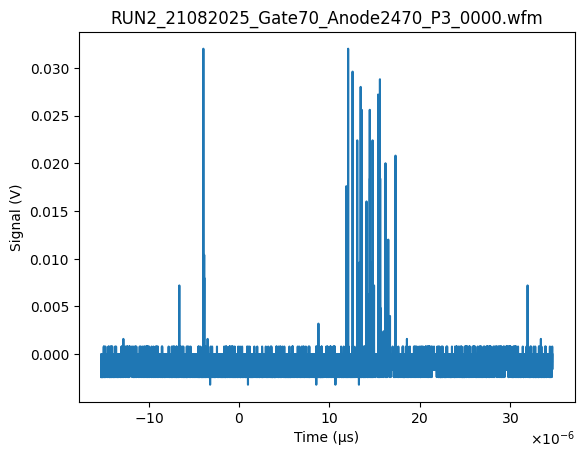

In [14]:
wf.plot()

# Test measurement module

In [50]:
set70 = meas.SetPmt.from_directory(meas_path)
set70.filenames[:3]
set70.metadata['anode'], set70.metadata['gate'], set70.metadata.get('gate')

(2470, 70, 70)

In [51]:
set70 = meas.set_fields(set70, drift_length=drift_length, EL_gap=EL_gap, gas_density=4.91e19)
set70.drift_field, set70.EL_field, set70.red_drift_field

(50.0, 3000.0, 0.10183299389002036)

In [52]:
set70 = meas.set_transport_properties(set70, drift_length=1.4, transport=None)
set70.time_drift

np.float64(17.13152509716977)

In [53]:
set70 = meas.estimate_s1_from_batches(set70, height_S1=0.001, batch_size=10)
set70.metadata['t_s1'], set70.metadata['t_s1_std']

(-4.804662962962962e-06, 3.0923867195813454e-06)

In [54]:
set70 = meas.estimate_s1_from_batches(set70, batch_size=20, height_S1=0.001)
set70.metadata['t_s1'], set70.metadata['t_s1_std']

(-4.8293628318584055e-06, 3.2547585260727574e-06)

## Test cuts

In [72]:
# pass_drift = cuts.amplitude_window_cut(wf, (t_s1, set70.time_drift + 1e-6), threshold=0.05, nmax_grass=5)
# pass_bs, pass_drift
baseline = cuts.make_baseline_cut(bs_window=bs_t_window, threshold=0.01, nmax_grass=5)
baseline(wf)

drift_cut = meas.drift_region_cut(set70, t_tol=1e-6, threshold=0.02, nmax_grass=5)
drift_cut(wf)

post_s2_cut = meas.post_s2_cut(set70, width_s2=1e-5, threshold=0.02, nmax_grass=5)
post_s2_cut(wf)


np.True_

In [213]:
baseline_log = meas.apply_cut(set70, cuts.make_baseline_cut, "baseline", "Stable baseline")
drift_log    = meas.apply_cut(set70, meas.drift_region_cut(set70, t_tol=1e-6), "drift", "Clean drift")
post_log     = meas.apply_cut(set70, meas.post_s2_cut(set70, width_s2=1e-5), "post_s2", "No noise after S2")

all_log = meas.combine_logs([baseline_log, drift_log, post_log])


# len(set70.filenames), len(clean_set.filenames)

In [211]:
# Filter the set to only clean waveforms
clean_set = meas.filter_set(set70, all_log)
drift_set = meas.filter_set(set70, drift_log)
post_set = meas.filter_set(set70, post_log)
base_set = meas.filter_set(set70, baseline_log)

In [212]:
len(clean_set), len(drift_set.filenames), len(post_set), len(post_set), len(base_set)

(904, 904, 3000, 3000, 3000)

In [208]:
# plotting.plot_waveform_with_cuts(wf, set70, width_s2=1e-5,)
import inspect
inspect.getfullargspec(drift_log.cut_fn)

FullArgSpec(args=['wf'], varargs=None, varkw=None, defaults=None, kwonlyargs=[], kwonlydefaults=None, annotations={})

In [209]:
cut_list = [
    ("baseline", cuts.make_baseline_cut(bs_t_window), "Stable baseline"),
    ("drift_region", meas.drift_region_cut(set70, t_tol=1e-6), "Clean drift region"),
    ("post_s2", meas.post_s2_cut(set70, width_s2=1e-5), "No noise after S2"),
]

logs = [meas.apply_cut(set70, fn, name, reason) for name, fn, reason in cut_list]
clean_set = meas.filter_set(set70, logs)

In [ ]:
set_process = meas.pipe(
    set70,
    lambda s: meas.set_fields(s, drift_length, EL_gap, gas_density),
    lambda s: meas.set_transport_properties(s, drift_length, transport),
    meas.estimate_s1_from_batches,
    # lambda s: meas.evaluate_cuts(s, bs_t_window),
    # lambda s, l: meas.filter_set(s, l),
)


In [ ]:
log

[RejectionLog(cut_name='baseline', cut_fn=<function make_baseline_cut.<locals>.cut at 0x116d46dc0>, passed=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 202, 20

# Test plotting module

In [223]:
drift_log.cut_fn.__closure__

(<cell at 0x113e37130: int object at 0x1002329b0>,
 <cell at 0x1170e3b80: numpy.float64 object at 0x1170fe1d0>,
 <cell at 0x1170e3d00: float object at 0x112033f10>,
 <cell at 0x1170e3640: float object at 0x1139e1170>)

In [66]:
set70.metadata['t_s1']

-4.8293628318584055e-06

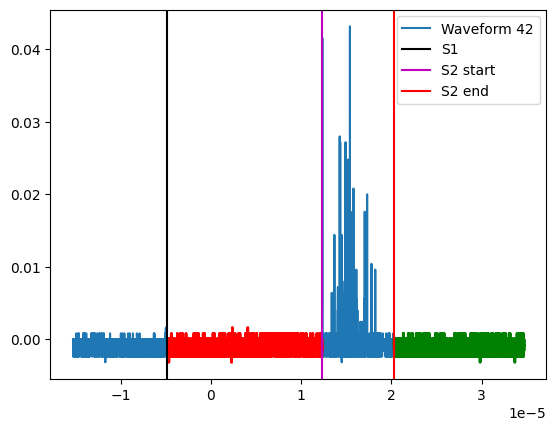

In [144]:
wf = dataIO.load_wfm(set70.source_dir / set70.filenames[42])
plotting.plot_cut_results(wf, set70, logs, wf_index=42, width_s2=8e-6)

In [ ]:
%matplotlib inline
# fig, ax = plt.subplots()
plotting.scroll_waveforms(set70, logs, width_s2=8e-6)

IntSlider(value=0, max=2999)

Output()

In [184]:
all_log

RejectionLog(cut_name='all_cuts', passed=[2, 5, 9, 10, 17, 18, 20, 21, 24, 27, 29, 38, 50, 51, 54, 59, 60, 72, 74, 75, 78, 82, 84, 88, 91, 92, 93, 96, 108, 109, 110, 111, 112, 113, 114, 115, 121, 122, 123, 124, 127, 129, 136, 143, 144, 146, 150, 156, 157, 160, 161, 164, 166, 168, 182, 186, 193, 199, 202, 203, 206, 210, 214, 217, 218, 220, 221, 229, 230, 233, 234, 235, 249, 252, 256, 258, 259, 260, 264, 269, 271, 278, 279, 284, 287, 291, 293, 296, 306, 309, 311, 314, 315, 322, 338, 341, 345, 350, 353, 355, 357, 367, 368, 369, 371, 372, 377, 379, 380, 399, 400, 402, 408, 411, 413, 418, 424, 426, 428, 429, 430, 431, 435, 437, 439, 442, 445, 446, 447, 450, 451, 455, 456, 457, 460, 464, 466, 467, 468, 480, 482, 487, 498, 499, 502, 505, 506, 515, 516, 518, 524, 525, 526, 533, 537, 538, 545, 549, 552, 553, 557, 559, 562, 572, 578, 581, 582, 584, 590, 596, 602, 606, 608, 618, 619, 623, 627, 628, 631, 636, 637, 638, 641, 643, 645, 646, 654, 655, 658, 659, 661, 668, 672, 677, 678, 682, 687, 688,

IntSlider(value=0, max=903)

Output()

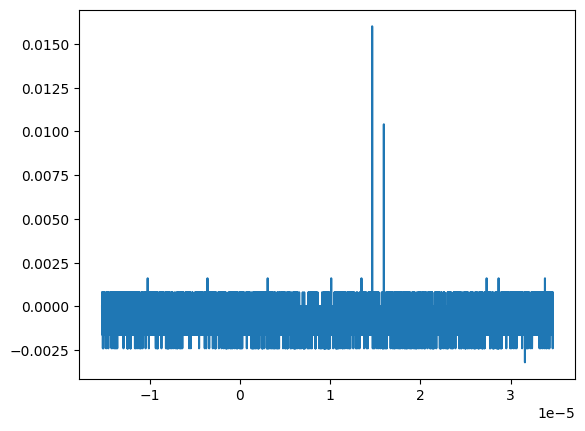

In [180]:
%matplotlib inline
# fig, ax = plt.subplots()
plotting.scroll_waveforms(clean_set, [all_log], width_s2=8e-6)

In [178]:
# %matplotlib widget
# fig, ax = plt.subplots()
# plotting.slideshow(set70, logs, width_s2=8e-6, delay=1.0, ax=ax)